今天的工作小结：
1. SSD-Mobilenet可以用keras在WIDERface上训练，以后可以考虑拓展到torch以及tf2。今天因为时间原因还在玩模型，希望明天能有可以呈现的结果拿出来。今天用WIDERface训练了一个小模型，看loss和accuracy是没问题的，但testing的代码应该是有点问题，要搞一搞visualization
2. CycleGAN应该是可以生成更多训练图片的(见下图）

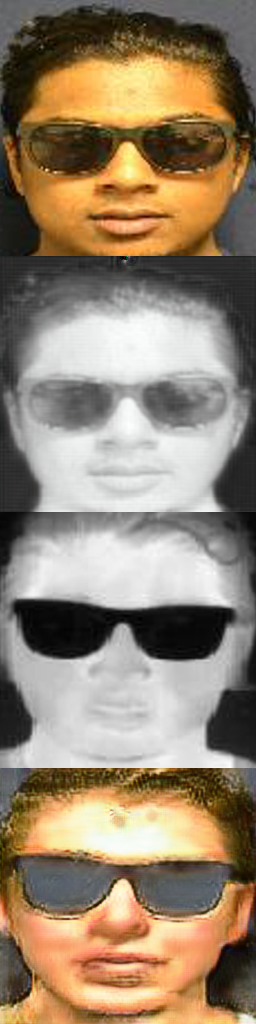
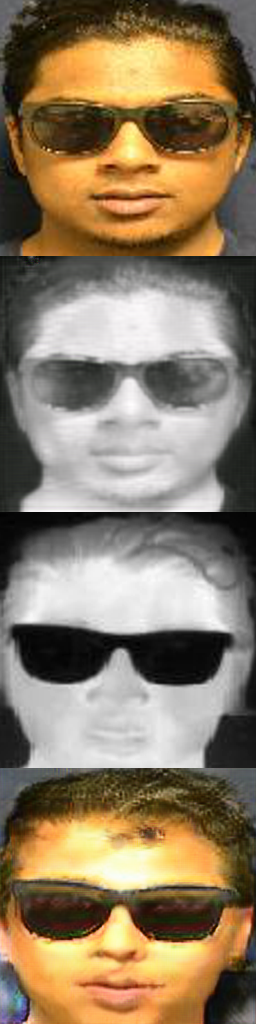

也总结一下这段时间的工作吧。基本没有怎么管face landmark的事情，可能最后依然会去训练一个端到端的把detection和landmark直接结合到一起的模型？我们现在有了红外+RGB一一对应的数据，可以考虑做一下了。主要是detection花的时间显著的比landmark要长，所以detection的速度上去了这个过程也就没有了瓶颈。Face tracking方面KCF一马当先（反正我是没有理解为什么SiamMask大家说好用），是一个把理论和实践完美结合的佳作。应该说现在这样的作品越来越少了，AI领域需要更多像Kingma et al 2014 与 Rezende et al 2013这样的论文

可以说这段时间一直在恶补face detection方面的知识。毕竟目标是在正常移动端跑detection到30fps的速度，现在的SOTA也不过如此吧。机器学习方面，opencv版的Viola-Jones应该就是极限了，速度可以达到5fps，但准确率没有3fps的dlib高。摒弃了陈旧的套路之后，我们发现mtcnn可以达到7fps的速度。或许是mtcnn准确率确实不高（还是比机器学习好用的）的原因，似乎之后几年大部分研究人员的目标都是提高几个百分点的准确率, as is the case in all other areas of deep learning。

下一个速度的革新点是YOLO，而看了YOLO的设计，我就发现之前一直没有人做的原因只是因为实时检测没有市场而已。轻便型的YOLO在速度上又有提升，可以达到12fps的样子。在此之后，Google推出了Mobilenet，结合YOLO或者SSD来做目标检测的速度就达到了15fps，值得庆祝。这样的速度基本达到现在的SOTA，结合一些优化以及tracking还是可以达到实时检测的要求的。

YOLO与SSD的设计相对简单，或许我应该说object detection这方面的网络就是很简单的设计，大概是发展没有object recognition久的缘故？希望日后YOLO的作者也能像mobilenet的作者一样，不要只看模型的设计，而去研究一下模型在训练时候很多内在的东西，才能产生更高效的代码。


重点：
为什么这么说呢？Mobilenetv1的主要创新点在于depthwise separable convolution，就是把正常的卷积分离开来只用1x1来增加通道数，可以显著增加计算速度（一般8～9倍），这个以后可以写得更详细，现在因为这个道理比较好理解就先不多写了

详见https://zhuanlan.zhihu.com/p/70703846

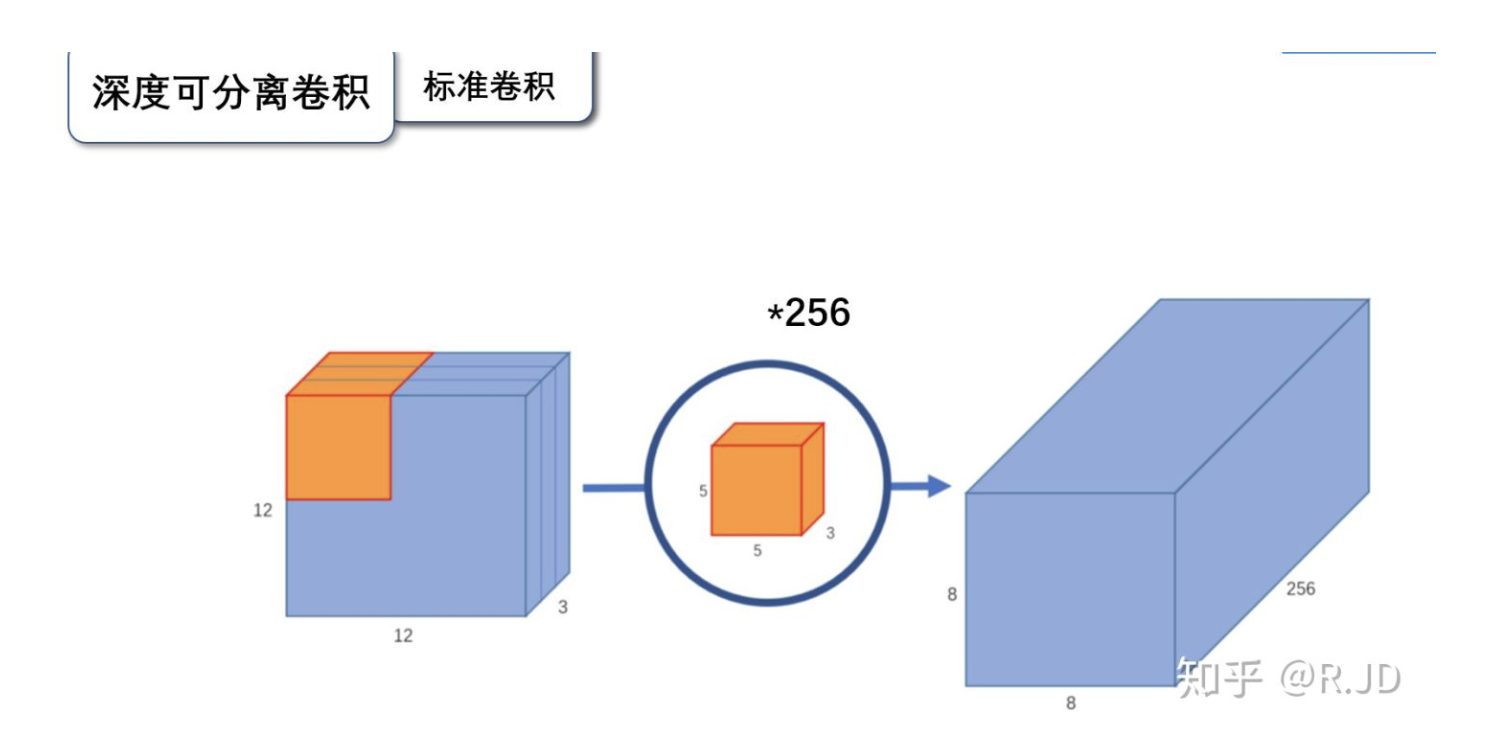
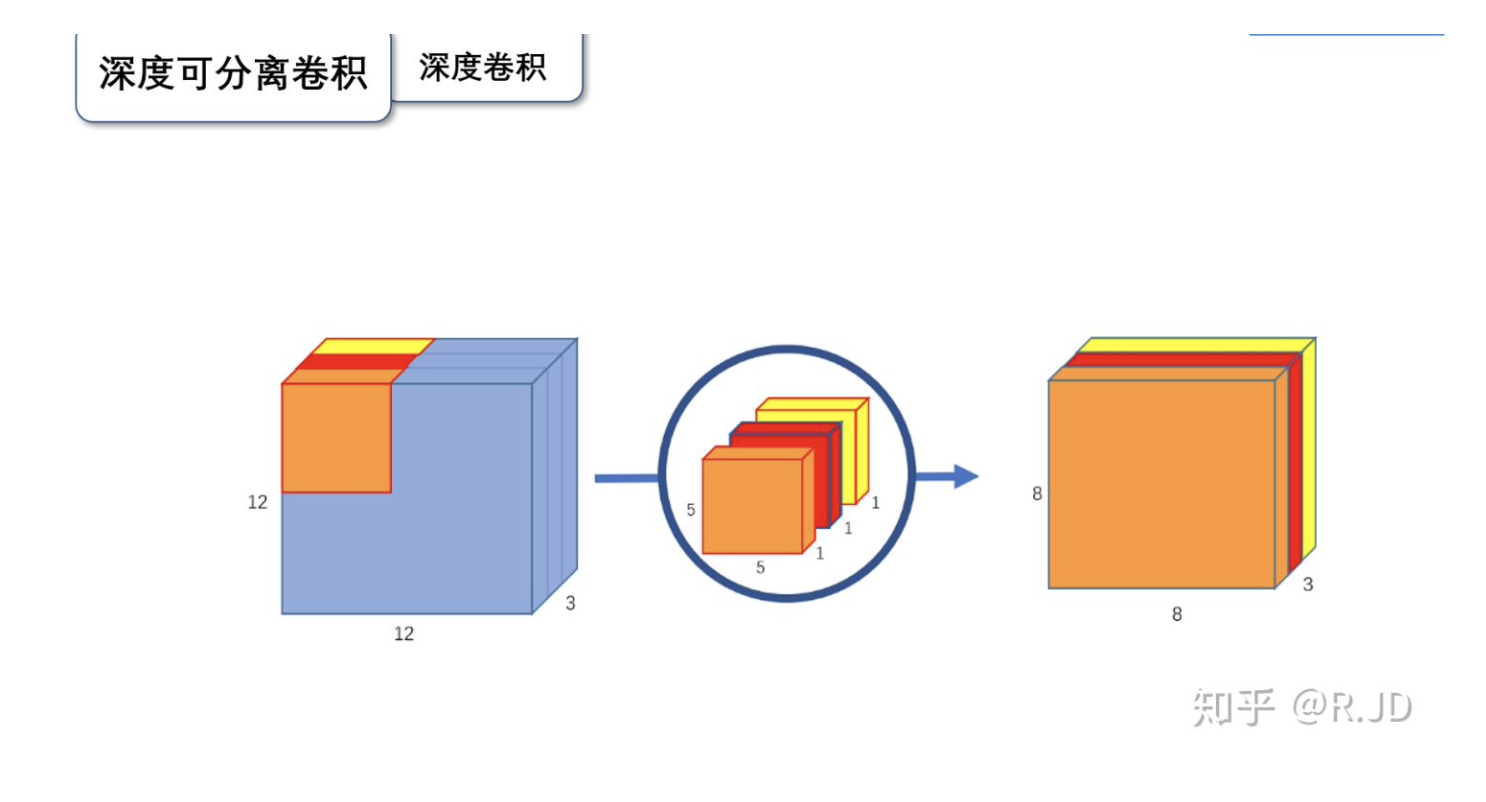

重点（ahem！敲黑板！）：个人认为下面一段把mobilenetv2总结的还是比较明白的，希望也有启发作用

Mobilenetv2通过观察训练时的权重，发现很多权重都是0。这本身并不惊人，我们都知道ReLU除了能把大于零的值原版照抄，剩下的统统归零。但仔细一想会发现一个不合理的地方：如果一层里面的数值要么是0，要么是正数的话，ReLU就变成了一个linear transformation（y = x）。这是很有可能发生的，只要ReLU的层数够多，很有可能中间会有几层完全起不到非线性连接层的效果，毕竟ReLU只是一个两段式的piecewise function。然而，在我们找到更好用的激活函数之前，还是先不要说ReLU不管用吧。

作者还发现，对于像ReLU这样容易丢失信息的函数，如果input是“藏在”高维数据中的低维数据的话，ReLU就不会丢掉很多信息。这其实很好理解，如果信息的表达无法完全占据整个空间的话当然更不容易丢失重要信息（采样往往面临的是同样的困境，不管是简单的MC还是拓展版的HMC）。在feature size不变（padding=’same'）的情况下，维度可以被简单地等同于通道的数量。

将以上两个observation结合起来，作者就产生了与教科书深度学习背道而驰的想法：如果我们在网络的中间用比较窄的线性连接层来代替一些ReLU会怎样？这样既解决了ReLU归零的问题，又可以“强迫”线性连接层输入到ReLU中的数据一定是低维的。事实证明，这确实对于提高准确率有显著的效果